In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

%matplotlib inline
from style import sns
%matplotlib inline

from scipy.special import expit
import copy

from population_matching.propensity import propensity_score_match
from population_matching.visualization import *
from population_matching.utils import MatchingData, split_target_pool
from population_matching.utils import GammaBalance
!pip3 freeze > hyperparameter_optimization_requirements.txt


Despite the intimidating names given to methods like _tree-structured Parzen estimation_, hyperparameter optimization algorithms are extremely intuitive and easy to understand.

## Introduction


### Hyperparameter optimization

This post came about as a rebellion against obfuscation. I was trying to optimize the hyperparameters of a classification model and came across an interesting-looking paper [1]. Unfortunately, the paper is dense with mathematics and gave me no intuitive insight into what's happening. As I dug deeper, I found that the ideas they were presenting are _absurdly_ simple (thanks partly to the post in [2]) and I wanted to capture my own take on this simplicity for future reference.

I will do this in the actual setting in which my use case arose: propensity score (PS) matching. There are some prerequisites for this discussion, which I unfortunately have to assume. If you aren't familiar, the classic reference on PS matching is [3], although I find the more recent review in [4] to be more accessible. In any case, suffice it to say that in PS matching, one trains a binary classification model and needs somehow to choose the "best" possible model over a large space of modeling choices.

I refer to these modeling choices as _hyperparameters_. For me, a hyperparameter is _any_ decision you make along the way to making a prediction with a model that cannot be optimized by gradient descent. I like this definition because it includes preprocessing operations that sometimes aren't thought of as hyperparameters. For instance, do you subtract the mean from your variables before optimizing the model parameters? This choice is a hyperparameter: subtract_mean $\in \{True, False\}$. In many cases, there is conventional wisdom around certain choices and these choices have a well-chosen default, but the choice is there, it affects your analysis, it can't be optimized by gradient descent and it's therefore by my definition a hyperparameter.

More conventional hyperparameters are quantities like regularization strength (which was discussed [in a previous post](regularization.html) ), type of regularization (e.g., L1 versus L2, discussed in the same post), maximum tree depth for a tree-based model, number of estimators in an ensemble method, number of layers in a multi-layer perceptron, and even the choice of which model to use. A bad choice for hyperparameters can lead to poor performance in your model, so it's worthwhile to spend time thinking about how one can best optimize an objective function over these hyperparameters.

In this post, we will motivate the need for hyperparameter optimization and give a very high level explanation of how two popular hyperparameter optimization approaches (tree-structured Parzen estimation and Gaussian process regression) work. The main goal is to break through the jargon and emphasize the intuition behind these methods. There will be minimal mathematics and we will not be rigorous! We will then demonstrate tree-structured Parzen estimation in action applied to PS hyperparameter optimization.

### Propensity score matching

We want to answer the question: does treatment X cause outcome Y? The ideal approach to answering such a question is the randomized control trial; however, it's often very impractical to perform such a trial. Meanwhile, there exists a wealth of high quality data that potentially already contain the cause-effect signal we're interested in, for instance, electronic health record data generated through routine medical practice.

When the intervention is not randomly assigned, there will often be systematic differences between treatment groups, which may obscure the causal signal if not taken into account. It turns out that by "matching" patients on their probability of treatment assignment, referred to as their _propensity score_, one can generate groups of patients with identical distributions of baseline covariates. It follows then that one can compare outcomes in these matched groups and obtain an unbiased estimate of the treatment effect. For details, see [3] and [4].

This all works _in theory_, when the propensity score is known. However, the propensity score is never known in observational settings and must be estimated from the data. The estimation of the propensity score from the data requires modeling choices and we want to choose the "best" propensity score model over a large space of possible models. Here, we diverge a bit from traditional machine learning practices. Since the end goal is balance in the baseline covariates, we use this as an optimization target. Whereas traditionally one would use an "out-of-sample" measure of model performance, here out-of-sample behavior is not relevant.

We define the following procedure for optimizing the hyperparameters of the propensity score model: <br>

  1. Choose a set of hyperparameters <br>
  2. Train a model to predict P(treat|covariates) <br>
  3. Perform matching on the estimated propensity score <br>
  4. Evaluate the achieved covariate balance <br>
  
Our focus will be on how to implement step (1) such that we arrive quickly at a good set of hyperparameters, since steps (2) and (3) can be quite time-consuming. For (4), we compute the area between the 1-dimensional marginal distributions as a measure of balance to be optimized. 

## Simulation Setup


To start, we'll simulate a toy dataset consisting of two covariates. To make the example more tangible, we'll give the covariates names. One will be BMI, the other will be eGFR. We're interested in studying the effect of a certain medication on a patient population as seen in electronic health record databases. The problem: both BMI and eGFR influence the treatment decision by practicing physicians. The medication is not prescribed to patients that are extremely overweight, nor to patients that are extremely underweight. Furthermore, the medication is not prescribed to patients with poor kidney function (low eGFR), nor is it prescribed to patients with normal kidney function (high eGFR). As a result of the interaction between these covariates and the treatment decision, we cannot simply compared treated and untreated patients. We have to correct for these systematic differences through matching.

Below we show the distribution of patients and the simulated propensity score. The propensity score shown here represents the "true" (unknown) propensity score that generates the treatment decision. Our goal here is to estimate this quantity.

In [2]:
#| include: true
def make_bmi_egfr_blob(n_samples: int) -> pd.DataFrame:
    
    # We mode eGFR to have a mean of 55 and a spread of +/- 40
    # and clip to range [5, 120]. This clipping is actually common
    # as often measurements just report >= 120.
    egfr = 55 + 40 * np.random.power(1, n_samples) * np.random.choice([-1, 1], size=n_samples)
    egfr = np.clip(egfr, 5, 120)
    
    # We model BMI to have mean 20 and a spread +/- 10 and
    # clip to range [2, 80].
    bmi = 20 + 10 * np.random.randn(n_samples)
    bmi = np.clip(bmi, 2, 80)

    features = pd.DataFrame.from_records(
        np.vstack((egfr, bmi)).T,
        columns=['eGFR', 'BMI']
    )
    
    return features

def ps_true(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    # propensity score is a circle of radius == standard deviation around the mean
    x_ = (x - x.mean()) / x.std()
    y_ = (y - y.mean()) / y.std()
    return expit( - (x_**2 + y_**2 ) )

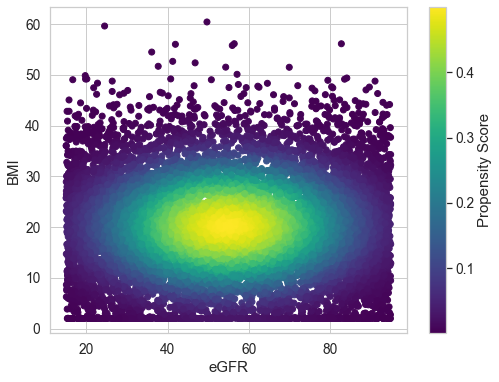

In [3]:
#| label: fig-input-distributions
#| fig-cap: "Scatter plot showing the BMI and eGFR values of the simulated patient population. Color indicates the true (and unknown) probability of treatment."
#| include: true
#| echo: false
%matplotlib inline

np.random.seed(1414)
n_samples = 10000

model_features = make_bmi_egfr_blob(n_samples)
ps_true = ps_true(model_features['eGFR'], model_features['BMI'])

plt.figure(figsize=(8,6))
plt.scatter(model_features['eGFR'], model_features['BMI'], c=ps_true, cmap='viridis')
plt.colorbar(label='Propensity Score')
_ = plt.xlabel('eGFR')
_ = plt.ylabel('BMI')

Given this assumed form for the true propensity score (i.e., the true probability of treatment assignment), we can now sample the realized treatment group assignment. In doing so, we get the distributions shown below for BMI and eGFR for the treated and untreated groups. We see that there are significant differences between the treated and untreated group other than the treatment. It would therefore not be fair to directly compare the health outcomes of the groups and then attribute differences in outcomes to the treatment.


In [4]:
#| include: true
treat_indicator = (np.random.rand(n_samples) <= ps_true).astype(int)
treat_label = ['treated' if t else 'untreated' for t in treat_indicator]

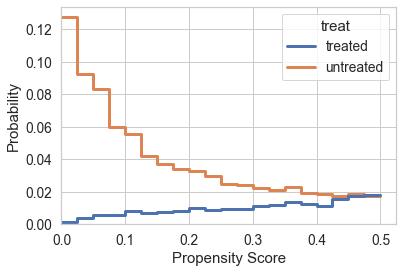

In [5]:
#| label: fig-ps-distributions
#| fig-cap: "Histogram of propensity scores in the assigned groups."
#| include: false
#| echo: false
model_features.loc[:, 'treat'] = treat_label
model_features.loc[:, 'propensity'] = ps_true
headers = {'numeric':['BMI', 'eGFR'], 'categoric':[]}
m = MatchingData(model_features, headers=headers, population_col='treat')
target, pool = split_target_pool(m)

sns.histplot(data = model_features, x='propensity', hue='treat', bins=20, stat='probability', fill=False, element='step', linewidth=3)
plt.xlim(xmin=0)
_ = plt.xlabel('Propensity Score')

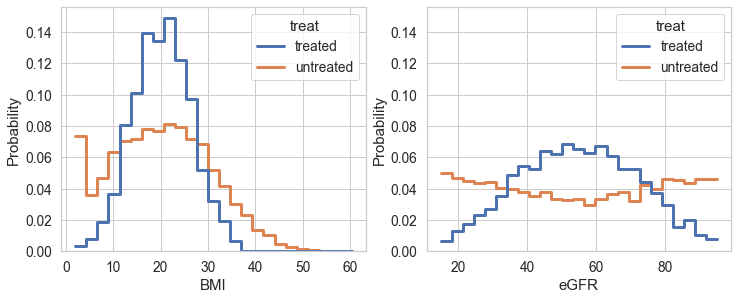

In [6]:
#| label: fig-intro
#| class: preview-image
#| fig-cap: "Simulated input distributions to the matching problem."
#| include: true
#| echo: false
_ = plot_numeric_features(m, cumulative=False, bins=25)

The number of patients in each group is given as below. The goal will be to choose a subset of patients from the untreated group such that distributions of BMI and eGFR in the chosen subset match the distributions in the treated group. 

In [7]:
#| include: true
#| echo: false
m.counts().sort_values('N', ascending=False)

,N
treat,
untreated,8024
treated,1976


## Matching on the true propensity score

In practice, we never have direct knowledge of the propensity score. But since we do in our simulation, let's first check what happens when we match using the true propensity score. Namely, for each patient in the treated group, we select a corresponding patient from the untreated group with a similar propensity score. The resulting population is denoted by the label "matched" in the figure below. This solution represents
the ideal case, the best we can hope to achieve with propensity score matching.

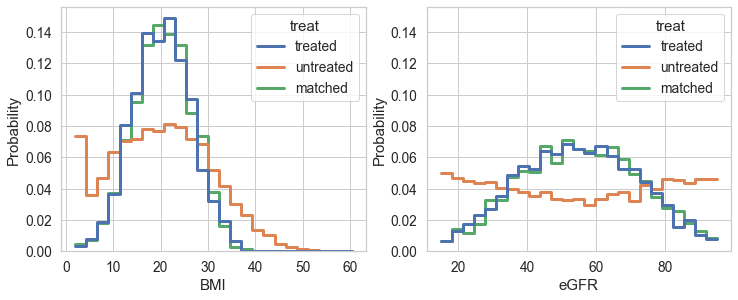

In [8]:
#| label: fig-true-ps-match
#| class: preview-image
#| fig-cap: "Result of matching using the true propensity score."
#| include: true
#| echo: false

hue_order = ['treated', 'untreated', 'matched']
matches_p, matches_t = propensity_score_match(pool['propensity'].values, target['propensity'].values, method='greedy')
match = copy.deepcopy(pool.iloc[matches_p])
match.loc[:, 'treat'] = 'matched'
match = pd.concat([match, target.iloc[matches_t]])
match = MatchingData(match, headers=headers, population_col='treat')
match.append(pool)
_ = plot_numeric_features(match, cumulative=False, bins=25, hue_order=['treated', 'untreated', 'matched'])

As you can see, propensity score matching delivers on its promise -- the covariates distributions of the population matched to the treated population on the propensity score  (green) are nearly identical to that of the treated population (blue). 

## Matching on estimated propensity score


In [9]:
def ps_true_ps_est_plot(ps: np.ndarray, ps_est: np.ndarray) -> None:

    fig, axes = plt.subplots(1, 3, figsize=(16, 6))
    axes[0].scatter(ps, ps_est, s=1)
    axes[0].grid(True)
    axes[0].plot([0, 0.5], [0, 0.5])
    axes[0].set_ylabel('Estimated PS')
    axes[0].set_xlabel('True PS')
    axes[0].set_title('PS-PS Compare')

    
    axes[1].scatter(model_features['eGFR'], model_features['BMI'], c=ps, cmap='viridis', vmin=0, vmax=0.5)
    axes[1].set_xlabel('eGFR')
    axes[1].set_ylabel('BMI')
    axes[1].grid(True)
    axes[1].set_title('True PS')

    axes[2].scatter(model_features['eGFR'], model_features['BMI'], c=ps_est, cmap='viridis', vmin=0, vmax=0.5)
    axes[2].set_xlabel('eGFR')
    axes[2].set_ylabel('BMI')
    axes[2].grid(True)
    axes[2].set_title('Estimated PS')

    fig.colorbar(axes[2].collections[0], label='Propensity Score')
    
def ps_match(model_features: pd.DataFrame, headers: dict, ps_est: np.ndarray) -> MatchingData:
    
    model_features.loc[:, 'ps_est'] = ps_est
    m = MatchingData(
        model_features, 
        headers=headers,
        population_col='treat')
    target, pool = split_target_pool(m)

    matches_p, matches_t = propensity_score_match(
        pool['ps_est'].values, 
        target['ps_est'].values,
        method='greedy')

    match = copy.deepcopy(pool.iloc[matches_p])
    match.loc[:, 'treat'] = 'matched'
    match = pd.concat([match, target.iloc[matches_t]])
    match = MatchingData(match, headers=headers, population_col='treat')
    match.append(pool)
    
    return match

Now let's see how well we can perform matching by estimating the propensity score. To start, let's try using a logistic regression to estimate the propensity score. As the logistic regression has linear decision boundaries, it should be clear that such a model would not be expected to perform well on this particular data, and indeed that is what we see.

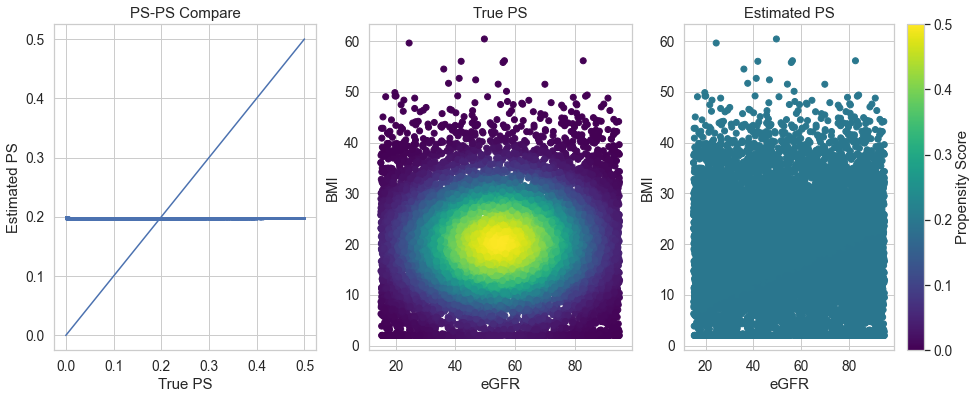

In [10]:
#| label: fig-log-reg-ps-match
#| class: preview-image
#| fig-cap: "Result of using logistic regression to model propensity score."
#| include: true
#| echo: true

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_features = scaler.fit_transform(model_features[['BMI', 'eGFR']])
clf = LogisticRegression()
clf.fit(normalized_features, treat_indicator)
ps_est = clf.predict_proba(normalized_features)[:, 1]
ps_true_ps_est_plot(ps_true, ps_est)

As seen in the left hand plot above, the model estimates the true PS very poorly. As a result, when we match using the estimated PS, we get very poor balance, as seen below. Although the distribution on BMI looks somewhat balanced, eGFR in the matched population is left completely unbalanced. This result is simply a consequence of our modeling choice, not a breakdown of the PS approach, since we know from above that matching works when we know the true PS.

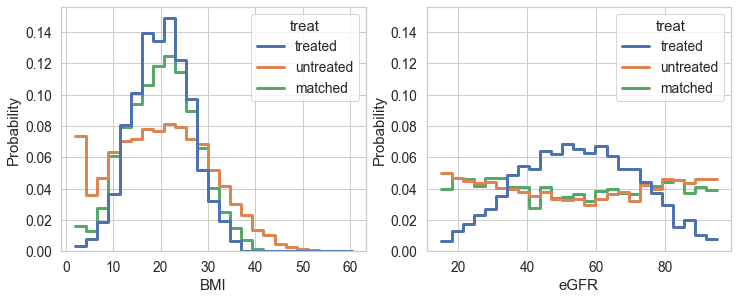

In [11]:
#| label: fig-log-reg-ps-match-balance
#| class: preview-image
#| fig-cap: "Achieved balance of PS matching using logistic regression model for PS."
#| include: true
#| echo: false

match = ps_match(model_features, headers, ps_est)
_ = plot_numeric_features(match, cumulative=False, bins=25, hue_order=['treated', 'untreated', 'matched'])

Since it's clear that the propensity score has some non-linearity to it, it make sense to next try using some sort of model that can capture this non-linearity. Let's try therefore a random forest model for the propensity score. To illustrate the point that bad hyperparameters can impact performance, I will purposely pick very poor hyperparameters for the random forest: max_depth=2, n_estimators=2 (for this toy problem, the default hyperparameters perform quite well, but in realistic problems this may not be the case). The resulting estimation for PS is shown below. Although the estimation is still quite poor, the random forest does seem to better model the PS than the logistic regression for these particular choices of hyperparameters.

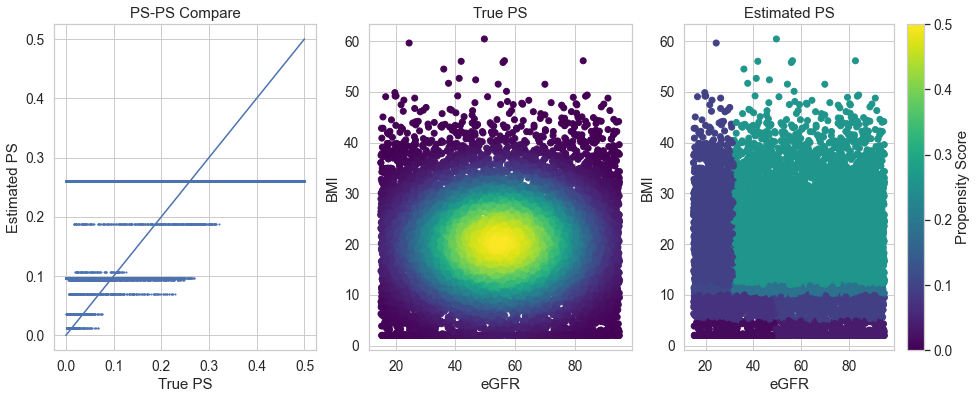

In [12]:
#| label: fig-rf-ps-match
#| class: preview-image
#| fig-cap: "Result of using random forest to model propensity score."
#| include: true
#| echo: true

from sklearn.ensemble import RandomForestClassifier
np.random.seed(124)
clf = RandomForestClassifier(max_depth=2, n_estimators=2, random_state=123)
clf.fit(normalized_features, treat_indicator)
ps_est = clf.predict_proba(normalized_features)[:, 1]
ps_true_ps_est_plot(ps_true, ps_est)

The poor performance of this choice of hyperparameters is also reflected in the resulting matched distributions, shown below. Although better than the logistic regression, it's clear that the matching is far from the ideal case of matching on the true PS. So we have some work left.

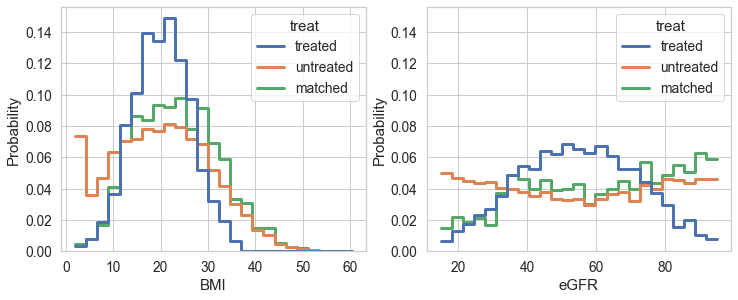

In [13]:
#| label: fig-rf-ps-match-balance
#| class: preview-image
#| fig-cap: "Achieved balance of PS matching using random forest model for PS."
#| include: true
#| echo: false

match = ps_match(model_features, headers, ps_est)
_ = plot_numeric_features(match, cumulative=False, bins=25, hue_order=['treated', 'untreated', 'matched'])

In [14]:
bc = GammaBalance(m, n_bins=10)
bc.distance(match.get_population('matched'))

Detected constant feature(s) in target population: BMI_7.0,BMI_8.0,BMI_9.0.


tensor(0.1618, dtype=torch.float64)

## Hyperparameter optimization

### Motivation and intuition

In [15]:
def ps_train_and_match(params, verbose=False):

    model, params = params
    if verbose:
        print(params)
    clf = model(**params)
    clf.fit(normalized_features, treat_indicator)
    ps_est = clf.predict_proba(normalized_features)[:, 1]
    
    model_features.loc[:, 'ps_est'] = ps_est
    m = MatchingData(
        model_features, 
        headers={'numeric':['x1', 'x2'], 'categoric':[]}, 
        population_col='treat')
    target, pool = split_target_pool(m)

    matches_p, matches_t = propensity_score_match(
        pool['ps_est'].values, 
        target['ps_est'].values,
        method='greedy')

    score = float(bc.distance(pool.iloc[matches_p]).numpy())
    if verbose:
        print(f'loss: {score:.4f}')
    
    return score


In [16]:
#| include: false
#| echo: true


from sklearn.model_selection import ParameterSampler

HYPERPARAM_SPACE = {
    LogisticRegression:{
        'C':[0.01, 0.1, 0.25, 0.5, 1, 10, 50, 75, 100],
        'penalty':['l1'],
        'solver':['saga']
    },
    RandomForestClassifier:{
        'n_estimators':[2],
        'max_depth':[2, 5, 10, 15, 20, 30, 40, 50],
        'random_state':[123]
    }
}
hyperparams = []
n_models = len(HYPERPARAM_SPACE)
for model, params in HYPERPARAM_SPACE.items():
    hyperparams.extend(
        [
            (model, p)
            for p in ParameterSampler(params, n_iter=100)
        ]
    )

np.random.shuffle(hyperparams)

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [17]:
balance = {'LogisticRegression':[], 'RandomForestClassifier':[]}
for hyperparam in hyperparams:
    score = ps_train_and_match(hyperparam, verbose=False)
    model = hyperparam[0]
    model_name = model().__repr__().split('.')[-1].strip('()')
    balance[model_name].append(
        [hyperparam[1][c] for c in sorted(hyperparam[1].keys())] + [score]
    )
balance


{'LogisticRegression': [[0.5, 'l1', 'saga', 0.1091240370180458],
  [10, 'l1', 'saga', 0.11596735501661898],
  [50, 'l1', 'saga', 0.11826896108686927],
  [100, 'l1', 'saga', 0.11916207438334825],
  [1, 'l1', 'saga', 0.11828529173508287],
  [0.01, 'l1', 'saga', 0.18460453152656559],
  [0.25, 'l1', 'saga', 0.10763119287148584],
  [75, 'l1', 'saga', 0.12437242968007924],
  [0.1, 'l1', 'saga', 0.18460453152656559]],
 'RandomForestClassifier': [[40, 2, 123, 0.1324873169651255],
  [5, 2, 123, 0.08720430634566584],
  [50, 2, 123, 0.13319956231571267],
  [20, 2, 123, 0.03240918866358697],
  [10, 2, 123, 0.010885704588145018],
  [2, 2, 123, 0.1618093382101506],
  [15, 2, 123, 0.020678305521141735],
  [30, 2, 123, 0.08590979143045843]]}

We've seen that the choice of hyperparameters makes a difference in the achieved balance. So let's try a few more choices of hyperparameters and see if we can find some improvements in the balance. For the logistic regression, we randomly sample a few values for the regularization strength $C$; for the random forest model, we randomly sample a few values for the max_depth, keeping the n_estimators fixed to 2, as before. The resulting balance (roughly, the total area between the 1D marginal distributions) as a function of these hyperparameters is shown below.

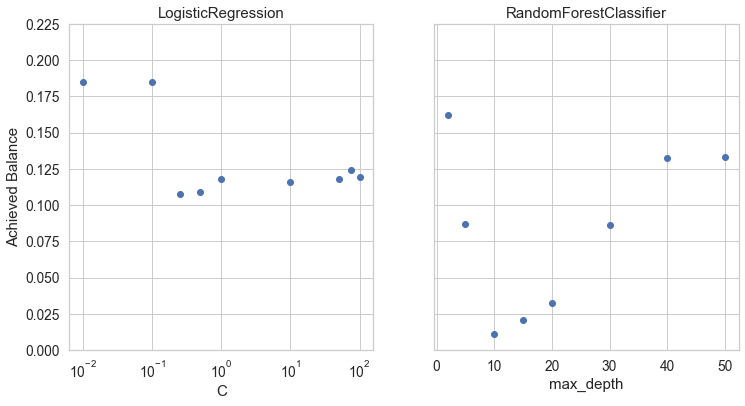

In [18]:
#| label: fig-hyperopt-random
#| class: preview-image
#| fig-cap: "Balance achieved by PS matching using various models for PS."
#| include: true
#| echo: false

C = [row[0] for row in balance['LogisticRegression']]
balance_lr = [row[-1] for row in balance['LogisticRegression']]
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)
axes[0].scatter(C, balance_lr)
axes[0].set_xlabel('C')
axes[0].semilogx()
axes[0].set_title('LogisticRegression')

max_depth = [row[0] for row in balance['RandomForestClassifier']]
balance_rf = [row[-1] for row in balance['RandomForestClassifier']]
axes[1].scatter(max_depth, balance_rf)
axes[0].set_ylim([0, 0.225])
axes[1].set_xlabel('max_depth')
axes[0].set_ylabel('Achieved Balance')
axes[1].set_title('RandomForestClassifier')
axes[0].grid(True)
axes[1].grid(True)


After trying a few values of hyperparameters, we've realized that training models takes a long time and we can only try a limited number of hyperparameters. Now that we have some information about how the achieved balance depends on our hyperparameters, it would make sense to use this information to choose the next point! If given only one more chance, which model would you pick? So far it looks like the random forest model is the better bet and furthermore, it might be useful to try a max depth between 5 and 15, as this seems to be the region of hyperparameter space where the balance is the best.

This simple calculation, which you just did in your brain instinctively, is really all there is to hyperparameter optimization by tree-structured Parzen estimation (TPE) or Gaussian process regression (GPR), at least conceptually.  For each model (logistic regression or random forest), we construct a "hypermodel" which predicts the expected balance on unseen values of the hyperparameters. We then use these hypermodels to guess a good set of hyperparameters to test next. The various methods refer simply to different ways of predicting what values of balance lie in between the sampled points and methods for choosing the next point to sample.

As an illustration, we show the result of fitting a Gaussian process to the sampled data points. We perform one GPR per model class (logistic regression or random forest). The plot below shows the mean +/- 1 standard deviation range for the predicted values on the intermediate points. We see that the Gaussian process is simply interpolating on the known points and giving additionally a measure of uncertainty in the interpolated values.

In [19]:
#| include: true
#| echo: true

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

gp_lr = GaussianProcessRegressor(normalize_y=True)
_ = gp_lr.fit(np.log([C]).T, balance_lr)

gp_rf = GaussianProcessRegressor(normalize_y=True, kernel=RBF(length_scale_bounds=(1, 100)))
_ = gp_rf.fit(np.array([max_depth]).T, balance_rf)

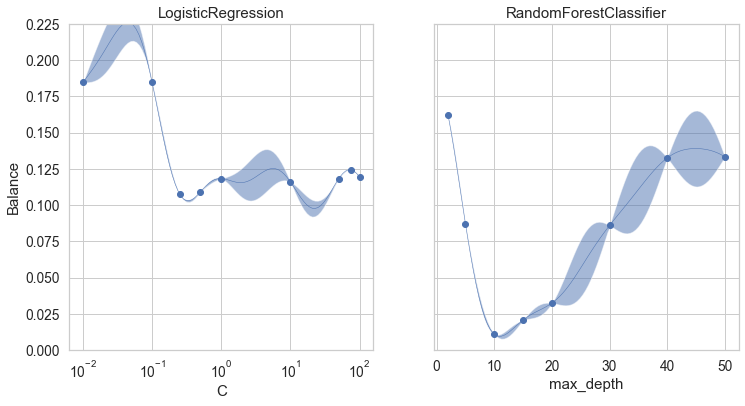

In [20]:
#| label: fig-hyperopt-gp-fit
#| class: preview-image
#| fig-cap: "Gaussian process fit to achieved balance as a function of the hyperparameters for each model type."
#| include: true
#| echo: false

fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

x = np.logspace(-2, 2, 100)
y = gp_lr.sample_y(np.log([x]).T, n_samples=1000)
mean = y.mean(axis=1)
std = y.std(axis=1)

axes[0].fill_between(x, mean - std, mean + std, alpha=0.5)
axes[0].plot(x, mean, c='b', lw=0.5)
axes[0].scatter(
    [row[0] for row in balance['LogisticRegression']],
    [row[-1] for row in balance['LogisticRegression']],
    c='b'
)
axes[0].set_xlabel('C')
axes[0].semilogx()
axes[0].set_title('LogisticRegression')


x = np.linspace(2, 50, 100)
y = gp_rf.sample_y(np.array([x]).T, n_samples=1000)
mean = y.mean(axis=1)
std = y.std(axis=1)

axes[1].fill_between(x, mean - std, mean + std, alpha=0.5)
axes[1].plot(x, mean, c='b', lw=0.5)
axes[1].scatter(
    [row[0] for row in balance['RandomForestClassifier']],
    [row[-1] for row in balance['RandomForestClassifier']],
    c='b'
)
axes[0].set_ylim([0, 0.225])
axes[0].set_ylabel('Balance')
axes[1].set_xlabel('max_depth')
_ = axes[1].set_title('RandomForestClassifier')

TPE works in a similar way, except instead of directly modeling $P$(balance|hyperparameters) as the GPR does, TPE models the distributions of "good" and "bad" points. That is, TPE splits all the sampled points into two categories based on some arbitrary threshold $B^*$. Those points with balance $> B^*$ are considered "bad" and those with balance $\leq B^*$ are considered "good". We then form a KDE (kernel density estimate  -- essentially, a fancy kind of histogram) for the good and bad points. And we do this for each model class. From these distributions, we sample the next hyperparameter according to the ratio $P$(good|hyperparameter) / $P$(bad|hyperparameter). The resulting sampling distribution is shown below for $B^*=0.125$. As we can see in the right-hand plot, the TPE approach seems to encode our intuition that sampling a point max_depth $\in$ [5, 15] next is a good idea. The choice of whether to sample from the logistic regression or random forest model hyperparameters is handled by yet another hypermodel, not shown.


In [21]:
#| include: true
#| echo: true

from sklearn.neighbors import KernelDensity

Bstar = 0.125

good_lr = [[c for c,b in zip(C, balance_lr) if b < Bstar]]
bad_lr = [[c for c,b in zip(C, balance_lr) if b >= Bstar]]
good_rf = [[d for d,b in zip(max_depth, balance_rf) if b < Bstar]] 
bad_rf = [[d for d,b in zip(max_depth, balance_rf) if b >= Bstar]]

bandwidth = 2
kernel = 'gaussian'
kde = KernelDensity(bandwidth=bandwidth, kernel=kernel)
good_lr_kde = kde.fit(np.log(good_lr).T)

kde = KernelDensity(bandwidth=bandwidth, kernel=kernel)
bad_lr_kde = kde.fit(np.log(bad_lr).T)

bandwidth = 5
kde = KernelDensity(bandwidth=bandwidth, kernel=kernel)
good_rf_kde = kde.fit(np.array(good_rf).T)

kde = KernelDensity(bandwidth=bandwidth, kernel=kernel)
bad_rf_kde = kde.fit(np.array(bad_rf).T)

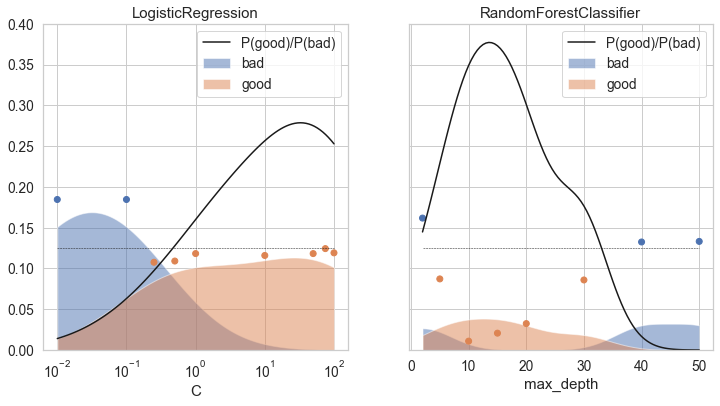

In [22]:
#| label: fig-hyperopt-tpe-fit
#| class: preview-image
#| fig-cap: "Sampling distribution obtained by fitting Gaussian KDEs to the observed values of the balance for each model type."
#| include: true
#| echo: false

fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
x = np.logspace(-2, 2, 100)
y_bad = np.exp(bad_lr_kde.score_samples(np.log([x]).T))
axes[0].fill_between(x, y_bad, 0, label='bad', alpha=0.5)
y_good = np.exp(good_lr_kde.score_samples(np.log([x]).T))
axes[0].fill_between(x, y_good, 0, label='good', alpha=0.5)
axes[0].scatter(C, balance_lr, c=[colors[0] if b > Bstar else colors[1] for b in balance_lr])
axes[0].plot(x, 0.25 * y_good/(1e-1 + y_bad), c='k', linewidth=1.5, label='P(good)/P(bad)')
axes[0].legend()
axes[0].set_xlabel('C')
axes[0].hlines(y=Bstar, xmin=min(x), xmax=max(x), linewidth=0.5, linestyle='--', color='k')
axes[0].semilogx()
axes[0].set_ylim([0, 0.4])
_ = axes[0].set_title('LogisticRegression')

x = np.linspace(2, 50, 97)
y_bad = np.exp(bad_rf_kde.score_samples(np.array([x]).T))
axes[1].fill_between(x, y_bad, 0, label='bad', alpha=0.5)
y_good = np.exp(good_rf_kde.score_samples(np.array([x]).T))
axes[1].fill_between(x, y_good, 0, label='good', alpha=0.5)
axes[1].scatter(max_depth, balance_rf, c=[colors[0] if b > Bstar else colors[1] for b in balance_rf])

axes[1].plot(x, y_good/(1e-1 + y_bad), c='k', linewidth=1.5, label='P(good)/P(bad)')
axes[1].legend()
axes[1].hlines(y=Bstar, xmin=min(x), xmax=max(x), linewidth=0.5, linestyle='--', color='k')
axes[1].set_xlabel('max_depth')
_ = axes[1].set_title('RandomForestClassifier')


### Tree-structured Parzen estimator in action

In [23]:
import sys
sys.path.append('/Users/sprivite/opt/anaconda3/lib/python3.9/site-packages')
from hyperopt import hp


So, now that we understand what the "fancy" hyperparameter optimization methods are doing at a very high level, let's see if we can use them to achieve even better balance. We will use the implementation of TPE from the [hyperopt](http://hyperopt.github.io/hyperopt/) library. To make things a little more interesting, we'll optimize not just over model choice (LogisticRegression or RandomForest), $C$ and max_depth, but also over the penalty type (L1 or L2) for logistic regression, n_estimators and min_samples_leaf for random forest (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for a description of these parameters). After running the TPE sampler for 1000 iterations, the code returns the best parameters found, shown below.


In [24]:
#| include: true

# define a search space
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval, Trials

space = hp.choice('model', [
    (LogisticRegression, {
        'C':hp.loguniform('C', -4.6, 4.6), # BASE E
        'penalty':hp.choice('penalty', ['l1', 'l2']),
        'solver':'saga'
    }),
    (RandomForestClassifier, {
        'n_estimators':hp.uniformint('n_estimators', 2, 100),
        'min_samples_leaf':hp.uniformint('min_samples_leaf', 1, 500),
        'max_depth':hp.uniformint('max_depth', 2, 30),
        'random_state':123
    })
])

# minimize the objective over the space
trials = Trials()
# np.random.seed(2345); The random seed is set above, if the notebook is run
# from the beginning, one gets reproducible results
best = fmin(ps_train_and_match, space, algo=tpe.suggest, max_evals=1000, trials=trials, verbose=False)

print('Best model found:')
for param in best.items():
    print(f'\t{param[0]:20}{param[1]}')
    

Best model found:
	max_depth           12.0
	min_samples_leaf    223.0
	model               1
	n_estimators        11.0


In [32]:
# trials.trials[0]

In [33]:
lr_results = [
    [t['misc']['vals']['C'][0], t['misc']['vals']['penalty'][0], t['result']['loss'], t['tid']]
    for t in trials.trials if t['misc']['vals']['model'] == [0]
]
lr_results = pd.DataFrame.from_records(lr_results, columns=['C', 'penalty', 'loss', 'trial'])

rf_results = [
    [t['misc']['vals']['max_depth'][0], t['misc']['vals']['n_estimators'][0], t['misc']['vals']['min_samples_leaf'][0], t['result']['loss'], t['tid']]
    for t in trials.trials if t['misc']['vals']['model'] == [1]
]
rf_results = pd.DataFrame.from_records(rf_results, columns=['max_depth', 'n_estimators', 'min_samples_leaf', 'loss', 'trial'])
rf_results       

,max_depth,n_estimators,min_samples_leaf,loss,trial
0,22.0,75.0,433.0,0.012946,0
1,7.0,85.0,275.0,0.014852,1
2,6.0,57.0,391.0,0.014655,2
3,22.0,83.0,291.0,0.012808,4
4,28.0,4.0,327.0,0.012258,9
...,...,...,...,...,...
877,14.0,5.0,152.0,0.007822,994
878,10.0,19.0,184.0,0.007282,995
879,7.0,22.0,266.0,0.008539,997
880,8.0,8.0,224.0,0.006068,998


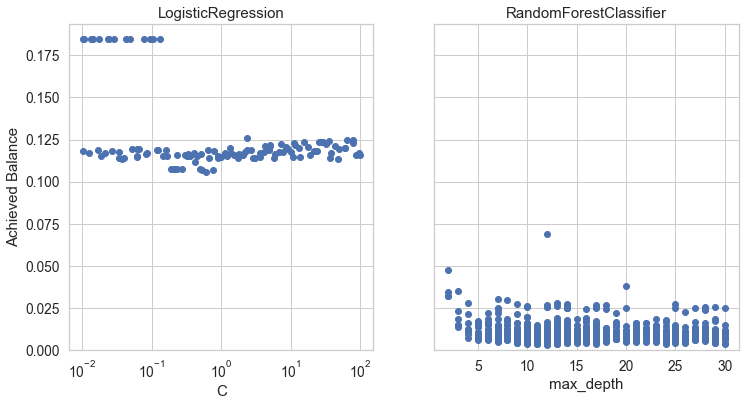

In [34]:
#| label: fig-hyperopt-tpe-1d
#| class: preview-image
#| fig-cap: "Achieved balance of various models for PS using TPE for hyperparameter sampling."
#| include: false
#| echo: false

fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)
axes[0].scatter(lr_results['C'], lr_results['loss'])
axes[0].set_xlabel('C')
axes[0].semilogx()
# axes[0].set_xlim([1e-2, 1e2])
axes[0].set_title('LogisticRegression')

axes[1].scatter(rf_results['max_depth'], rf_results['loss'])
axes[0].set_ylim(ymin=0)
axes[1].set_xlabel('max_depth')
axes[0].set_ylabel('Achieved Balance')
axes[1].set_title('RandomForestClassifier')
axes[0].grid(True)
axes[1].grid(True)

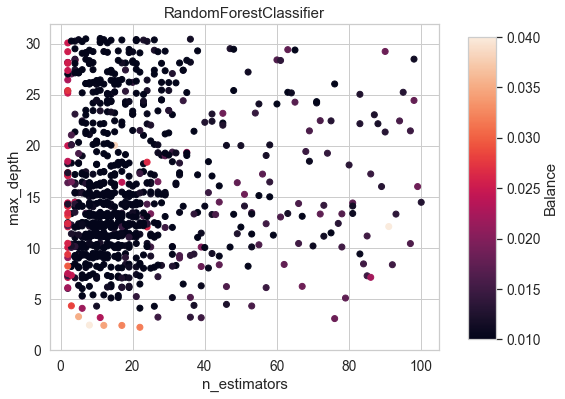

In [35]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

ax.scatter(
    rf_results['n_estimators'], 
    rf_results['max_depth'] + 0.5 * np.random.rand(len(rf_results)),
    c=rf_results['loss'],
    vmin=0.01, 
    vmax=0.04)
ax.set_ylim(ymin=0)
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_title('RandomForestClassifier')
ax.grid(True)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax.collections[0], cax=cbar_ax, label='Balance')

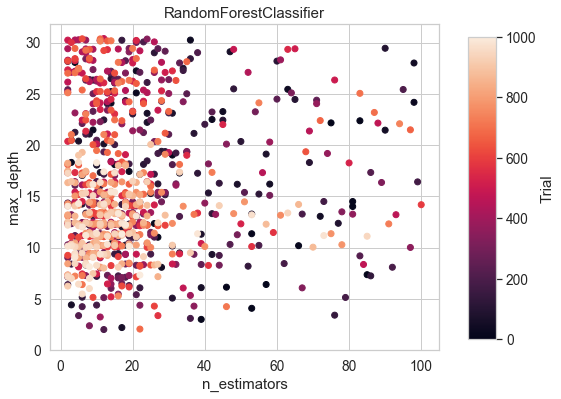

In [36]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

ax.scatter(
    rf_results['n_estimators'], 
    rf_results['max_depth'] + 0.5 * np.random.rand(len(rf_results)),
    c=rf_results['trial'],
    vmin=0, 
    vmax=1000)
ax.set_ylim(ymin=0)
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_title('RandomForestClassifier')
ax.grid(True)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax.collections[0], cax=cbar_ax, label='Trial')

In [37]:
df = pd.concat([
    lr_results[['trial', 'loss']], 
    rf_results[['trial', 'loss']]])
df = df.sort_values('trial')
df.loc[:, 'mean'] = df['loss'].rolling(50, min_periods=1).mean()
df.loc[:, 'min'] = df['loss'].rolling(1000, min_periods=1).min()
df

,trial,loss,mean,min
0,0,0.012946,0.012946,0.012946
1,1,0.014852,0.013899,0.012946
2,2,0.014655,0.014151,0.012946
0,3,0.116893,0.039836,0.012946
3,4,0.012808,0.034431,0.012808
...,...,...,...,...
878,995,0.007282,0.018057,0.003209
117,996,0.106675,0.019888,0.003209
879,997,0.008539,0.019985,0.003209
880,998,0.006068,0.019861,0.003209


Let's take a look at what the sampler did to arrive at this result. Below, I show how the sampling of the hyperparameter space evolves over time using the TPE method.

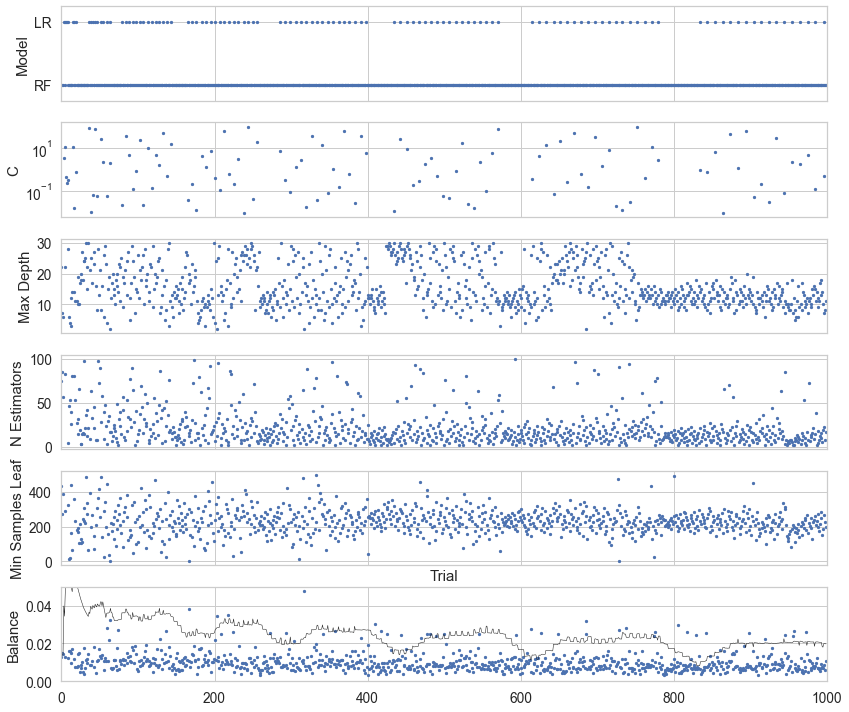

In [38]:
#| label: fig-parameter-sampling
#| class: preview-image
#| fig-cap: "An illustration of how the sampling of hyperparameters varies over time in 
#| the TPE approach. In the bottom panel, the black line indicates the average balance over the last 50 
#| samples and demonstrates how the TPE method is learning over time to suggest better and better 
#| hyperparameters."
#| include: true
#| echo: false

fig, axes = plt.subplots(6, 1, figsize=(12,10), sharex=True)
axes[5].scatter(
    lr_results['trial'].tolist() + rf_results['trial'].tolist(), 
    lr_results['loss'].tolist() + rf_results['loss'].tolist(), s=5)
axes[5].plot(df['trial'], df['mean'], c='k', label='mean', linewidth=0.5)
# axes[0].semilogy()
axes[5].set_ylabel('Balance')
axes[5].grid(True)
axes[5].set_ylim([0, 0.05])
axes[5].set_xlim([0, 1000])

axes[0].scatter(
    lr_results['trial'].tolist() + rf_results['trial'].tolist(), 
    [1]*len(lr_results) + [0] *len(rf_results), s=5)
# axes[0].semilogy()
axes[0].set_ylabel('Model')
axes[0].grid(True)
axes[0].set_xlim([0, 1000])
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['RF', 'LR'])
axes[0].set_ylim([-0.25, 1.25])

axes[1].scatter(lr_results['trial'], lr_results['C'], s=5)
axes[1].semilogy()
axes[1].set_ylabel('C')
axes[1].grid(True)
axes[1].set_xlim([0, 1000])

axes[2].scatter(rf_results['trial'], rf_results['max_depth'], s=5)
# axes[0].semilogy()
axes[2].set_ylabel('Max Depth')
axes[2].grid(True)
axes[2].set_xlim([0, 1000])

axes[3].scatter(rf_results['trial'], rf_results['n_estimators'], s=5)
axes[3].grid(True)
axes[3].set_xlim([0, 1000])
axes[3].set_ylabel('N Estimators')

axes[4].scatter(rf_results['trial'], rf_results['min_samples_leaf'], s=5)
axes[4].grid(True)
axes[4].set_xlim([0, 1000])
axes[4].set_ylabel('Min Samples Leaf')
plt.tight_layout()
_ = axes[4].set_xlabel('Trial')


We see a number of interesting features. In the top frame, we see that the sampler choose the logistic regression (LR) model less frequently over time; this is consistent with what we saw above, namely that the random forest model seems to perform better. The hypermodels of the TPE pick up on this fact and use it to preferentially choose the model that is showing the best results. 

We also see that the sampler explores the space rather uniformly in the first ~50-100 iterations. The sampler is doing this because it needs something to train its hypermodels on. Once it has some data to work with, the sampler can start taking more educated guesses about where to explore next. We see this in the time series of the samples for max_depth, n_estimators and min_samples_leaf. For later times, the sampler almost never chooses max_depth outside the range [5, 20]. It seems to have figured out that such values doesn't have a good chance of working out. Similarly, the sampler stops choosing n_estimators > 25 and zeros in on the range [100, 300] for min_samples_leaf after a while.

Note that the sampler never _completely_ stops exploring any region of parameter space. Especially as the number of hyperparameter dimensions grows large, there will always be unexplored regions of parameter space. Therefore, this occasional random exploration of the space, even when a good objective value seems unlikely, is useful to avoid missing out.

Finally, let's see what the matching results look like! Below, I show the resulting PS estimation using the best values for the hyperparameters found by the TPE sampler. Although the results are not perfect, we have clearly greatly improved upon the initial results.


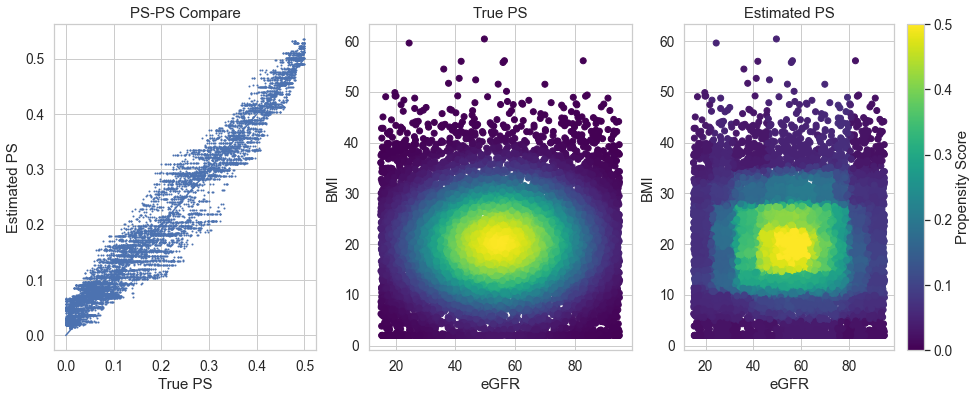

In [40]:
#| label: fig-main
#| class: preview-image
#| fig-cap: "Result of using TPE to find best hyperparameters to model propensity score."
#| include: true
#| echo: false
clf = RandomForestClassifier(**{'max_depth': 12, 'n_estimators': 11, 'min_samples_leaf':223, 'random_state':123})
clf.fit(normalized_features, treat_indicator)
ps_est = clf.predict_proba(normalized_features)[:, 1]
ps_true_ps_est_plot(ps_true, ps_est)

Furthermore, as shown below, the resulting matched populations look great! I would argue this match is hard to distinguish from the match above using the true propensity score. 

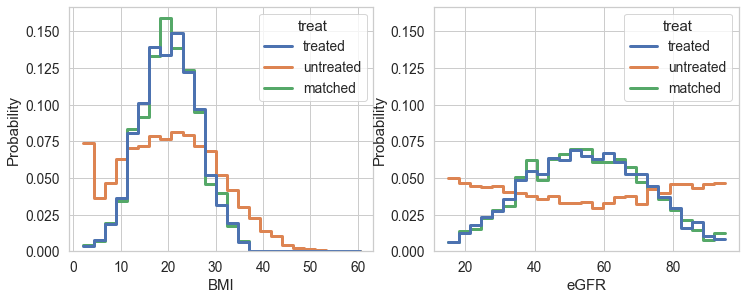

In [41]:
#| label: fig-tpe-ps-match-balance
#| class: preview-image
#| fig-cap: "Achieved balance of PS matching using best model achieved from TPE hyperparameter optimization."
#| include: true
#| echo: false

model_features.loc[:, 'ps_est'] = ps_est
m = MatchingData(
    model_features, 
    headers=headers,
    population_col='treat')
target, pool = split_target_pool(m)

matches_p, matches_t = propensity_score_match(
    pool['ps_est'].values, 
    target['ps_est'].values,
    method='greedy')

match = copy.deepcopy(pool.iloc[matches_p])
match.loc[:, 'treat'] = 'matched'
match = pd.concat([match, target.iloc[matches_t]])
match = MatchingData(match, headers=headers, population_col='treat')
match.append(pool)
_ = plot_numeric_features(match, cumulative=False, bins=25, hue_order=['treated', 'untreated', 'matched'])


## Conclusion

Hyperparameter optimzation is an important step in any machine learning workflow. Random sampling of hyperparameters is a very inefficient way to optimize hyperparameters, as our eyes can very quickly tell us. Tree-structured Parzen estimation and Gaussian process regression are a nice alternatives to random hyperparameter search, with easy-to-use Python implementations readily available. Although the methods sound intimidating, they are not much more than a formalization of what we would naturally do anyway if we were to manually choose hyperparameters to test.

## Further Reading

[1] [Algorithms for Hyper-Parameter Optimization](https://papers.nips.cc/paper_files/paper/2011/hash/86e8f7ab32cfd12577bc2619bc635690-Abstract.html).

[2] [Building a Tree-Structured Parzen Estimator from Scratch(Kind Of)](https://towardsdatascience.com/building-a-tree-structured-parzen-estimator-from-scratch-kind-of-20ed31770478).

[3] [The Central Role of the Propensity Score in Observational Studies for Causal Effects](https://www.jstor.org/stable/2335942).

[4] [An Introduction to Propensity Score Methods for Reducing the Effects of Confounding in Observational Studies](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/).

[5] [Hyperopt (Python library)](http://hyperopt.github.io/hyperopt/).
